In [106]:
from global_vars import *
from transformers import AutoModelForMultipleChoice, AutoTokenizer
from datasets import Dataset, load_from_disk
from tqdm import tqdm
import pandas as pd
import wandb
import pickle
import numpy as np
from wandb.keras import WandbMetricsLogger, WandbCallback
import tensorflow as tf
import os
from tensorflow.keras import Model # if only machine learning were this easy :P
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#import any other libraries you want here:
from tensorflow.keras.layers import Dense, SpatialDropout1D, LSTM, Embedding, GlobalAveragePooling1D
from tensorflow.keras.activations import softmax
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback, ModelCheckpoint

In [158]:
run = wandb.init(
    project="mbti_bert_mlm",
    config=dict,
    entity="mbtipredictor"
)

accuracy,▁▃█▄▆▄
epoch,▁▅█
loss,█▆▁▆▃▇
step_loss,█▅▃▃▂▁▁▃▆▂▄▃▃▅▅▆▅▄▃
val_accuracy,▇█▁
val_loss,▁█▃
accuracy,0.42
best_epoch,0
best_val_loss,2.78728
epoch,2
loss,1.61373


In [2]:
df = pd.read_csv("converted_new_for_custom.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106067 entries, 0 to 106066
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   posts    106067 non-null  object
 1   type     106067 non-null  object
 2   new_col  106067 non-null  int64 
 3   pad      106067 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.2+ MB


In [37]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 500
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['posts'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 256681 unique tokens.


In [47]:
X = tokenizer.texts_to_sequences(df['posts'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (106067, 500)


In [48]:
Y = pd.get_dummies(df['type']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (106067, 16)


In [49]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(95460, 500) (95460, 16)
(10607, 500) (10607, 16)


In [72]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)

(85914, 500) (85914, 16)
(9546, 500) (9546, 16)


In [135]:
xt= X_train[:100]
xv = X_val[:100]
xte = X_test[:100]
yt= Y_train[:100]
yv = Y_val[:100]
yte = Y_test[:100]

print(len(xt))

100


In [160]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2, name = "lstm_1", return_sequences=True))
model.add(LSTM(50, dropout=0.1, recurrent_dropout=0.1, name = "lstm_2", return_sequences=True))
model.add(GlobalAveragePooling1D(name = "globalaveragepooling1d"))
model.add(Dense(16, activation='softmax', name = "dense"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model.summary()



Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 500, 100)          5000000   
                                                                 
 spatial_dropout1d_21 (Spati  (None, 500, 100)         0         
 alDropout1D)                                                    
                                                                 
 lstm_1 (LSTM)               (None, 500, 100)          80400     
                                                                 
 lstm_2 (LSTM)               (None, 500, 50)           30200     
                                                                 
 globalaveragepooling1d (Glo  (None, 50)               0         
 balAveragePooling1D)                                            
                                                                 
 dense (Dense)               (None, 16)              

In [162]:
epochs = 3
batch_size = 10

In [147]:
log_loss_callback = LambdaCallback(
    on_batch_end=lambda batch, logs: wandb.log({'step_loss': logs['loss']}, step=batch)
)

validation_callback = LambdaCallback(
    on_batch_end=lambda batch, logs: 
        (print(logs.keys()), wandb.log({'step_val_loss': logs['val_loss']}, step=batch))
    if batch % 200 == 0 and 'val_loss' in logs else None
)

checkpoint_callback = ModelCheckpoint('my_model.h5', save_best_only=True)

In [163]:
history = model.fit(xt, 
                    yt, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    callbacks=[WandbCallback(), log_loss_callback],
                    validation_data=(xv, yv))

Epoch 1/3
10/10 [==============================] - ETA: 0s - loss: 2.7408 - accuracy: 0.2100

INFO:tensorflow:Assets written to: c:\Users\enoch\MBTIPredictor\wandb\run-20230317_213123-rm2yazt8\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\enoch\MBTIPredictor\wandb\run-20230317_213123-rm2yazt8\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\enoch\MBTIPredictor\wandb\run-20230317_213123-rm2yazt8\files\model-best)... Done. 0.2s


10/10 [==============================] - 22s 2s/step - loss: 2.7408 - accuracy: 0.2100 - val_loss: 2.6286 - val_accuracy: 0.2400
Epoch 2/3
10/10 [==============================] - ETA: 0s - loss: 2.3371 - accuracy: 0.2500

INFO:tensorflow:Assets written to: c:\Users\enoch\MBTIPredictor\wandb\run-20230317_213123-rm2yazt8\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\enoch\MBTIPredictor\wandb\run-20230317_213123-rm2yazt8\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\enoch\MBTIPredictor\wandb\run-20230317_213123-rm2yazt8\files\model-best)... Done. 0.2s


10/10 [==============================] - 19s 2s/step - loss: 2.3371 - accuracy: 0.2500 - val_loss: 2.2225 - val_accuracy: 0.2400
Epoch 3/3
10/10 [==============================] - ETA: 0s - loss: 2.1759 - accuracy: 0.2100

INFO:tensorflow:Assets written to: c:\Users\enoch\MBTIPredictor\wandb\run-20230317_213123-rm2yazt8\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\enoch\MBTIPredictor\wandb\run-20230317_213123-rm2yazt8\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\enoch\MBTIPredictor\wandb\run-20230317_213123-rm2yazt8\files\model-best)... Done. 0.2s


10/10 [==============================] - 18s 2s/step - loss: 2.1759 - accuracy: 0.2100 - val_loss: 2.1217 - val_accuracy: 0.2400


In [164]:
history = model.fit(X_train, 
                    Y_train, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_data=(X_val, Y_val),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001), checkpoint_callback, validation_callback, log_loss_callback])

Epoch 1/3
   1/8592 [..............................] - ETA: 12:30:02 - loss: 2.4653 - accuracy: 0.1000

KeyboardInterrupt: 

In [149]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [150]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

332/332 [==============================] - 55s 164ms/step - loss: 2.5999 - accuracy: 0.1606
Test set
  Loss: 2.600
  Accuracy: 0.161


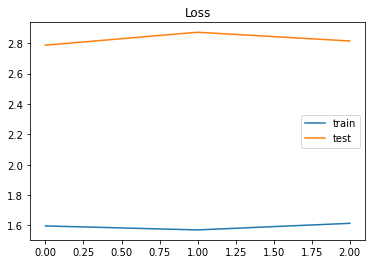

In [154]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

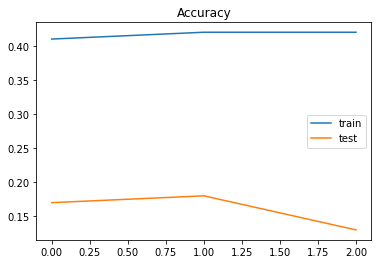

In [157]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [9]:
!mkdir -p saved_model
model.save('saved_model/my_model')


INFO:tensorflow:Assets written to: saved_model/my_model\assets


INFO:tensorflow:Assets written to: saved_model/my_model\assets


In [165]:
run.finish()

NameError: name 'run' is not defined